In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

train = '/Users/chanuka/Desktop/codespaces/liad/data/sim2_evalb/train.csv'
test = '/Users/chanuka/Desktop/codespaces/liad/data/sim2_evalb/test.csv'

train_data = pd.read_csv(train)
#test_data = pd.read_csv(test)

In [2]:
#train_data['started_at'] = pd.to_datetime(train_data['started_at'], utc=True)
#train_data['finished_at'] = pd.to_datetime(train_data['finished_at'], utc=True)

#test_data['started_at'] = pd.to_datetime(test_data['started_at'], utc=True)
#test_data['finished_at'] = pd.to_datetime(test_data['finished_at'], utc=True)

train_data['duration_min'] = (train_data['finished_at'] - train_data['started_at']).dt.total_seconds() / 60.0
#train_data['duration'] = train_data['duration_min'].clip(lower=0).fillna(0)

#test_data['duration_min'] = (test_data['finished_at'] - test_data['started_at']).dt.total_seconds() / 60.0
#test_data['duration'] = test_data['duration_min'].clip(lower=0).fillna(0)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

#### Train test descripancy

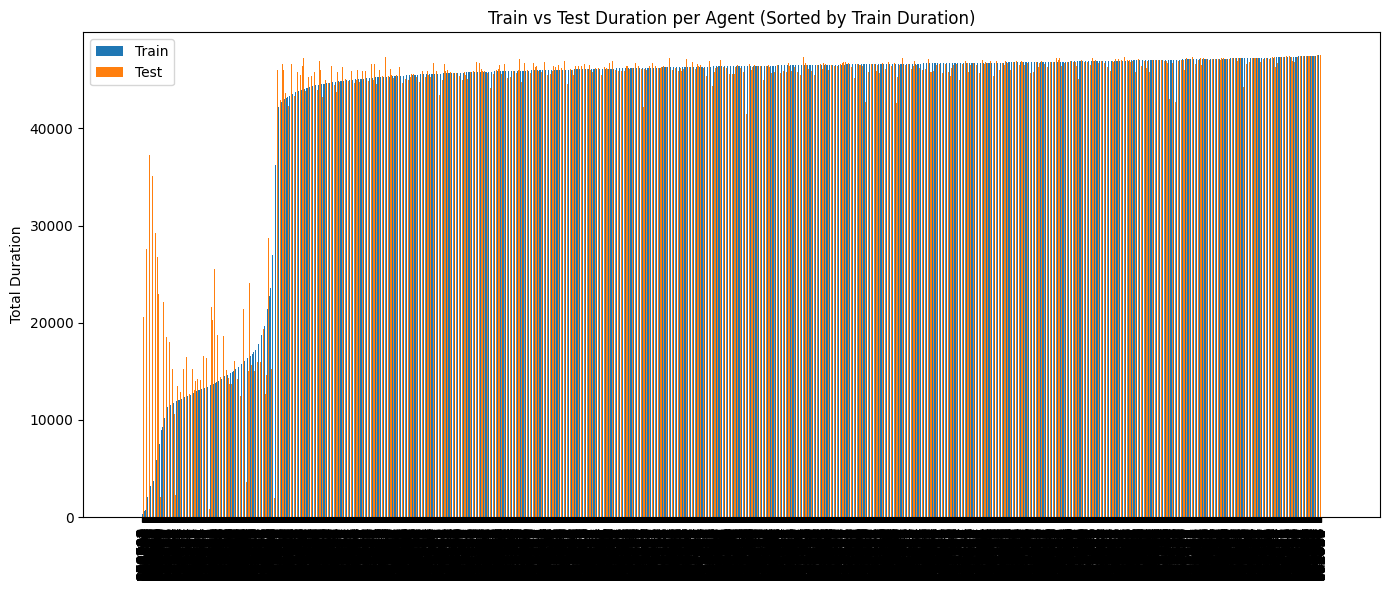

In [ ]:
train_agent_dur = train_data.groupby('agent')['duration_min'].sum()
#test_agent_dur = test_data.groupby('agent')['duration'].sum()

import matplotlib.pyplot as plt
import numpy as np

# Combine them into one DataFrame
df = pd.DataFrame({
    'train_duration': train_agent_dur #,
    #'test_duration':  test_agent_dur
}).fillna(0)

#df = df[(df['train_duration'] > 0) & (df['test_duration'] > 0)]
df =df[df['train_duration'] > 0]

# Sort by total (or you can sort by only train or only test)
df = df.sort_values(by='train_duration')   # or 'test_duration'

# Plot
plt.figure(figsize=(14, 6))

x = np.arange(len(df))
width = 0.4

plt.bar(x - width/2, df['train_duration'], width=width, label='Train')
#plt.bar(x + width/2, df['test_duration'],  width=width, label='Test')

plt.xticks(x, df.index, rotation=90)
plt.ylabel("Total Duration")
plt.title("Train vs Test Duration per Agent (Sorted by Train Duration)")
plt.legend()
plt.tight_layout()
plt.show()

#### with agent profiles

In [4]:
train = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/agent_profiles_train.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/agent_profiles_test.csv')

print(f"Training profiles: {len(train)} entries for {train['agent'].nunique()} agents")
print(f"Testing profiles: {len(test)} entries for {test['agent'].nunique()} agents")
print(f"\nCommon agents: {len(set(train['agent'].unique()) & set(test['agent'].unique()))}")

ground_truth = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/data/trail_4_sim1_fis/anomalous_agent_sim1.csv')
print(f"Ground truth: {len(ground_truth)} anomalous agents")
print(f"Unique agents in ground truth: {ground_truth['agent'].nunique()}")

Training profiles: 110995 entries for 9519 agents
Testing profiles: 110372 entries for 9498 agents

Common agents: 9017
Ground truth: 259 anomalous agents
Unique agents in ground truth: 259


In [2]:
def compute_components(train_profiles, test_profiles):
    merged = pd.merge(
        test_profiles, 
        train_profiles, 
        on=['agent', 'day_type', 'time_segment'],  # include agent here
        suffixes=('_test', '_train'), 
        how='left'
    )

    # Fill numeric training columns with 0 if no history exists for that slot
    numeric_cols = ['unique_location_ids_train', 
                    'avg_distance_from_home_km_train', 
                    'avg_speed_kmh_train']
    merged[numeric_cols] = merged[numeric_cols].fillna(0)

    # Component 1: Count Difference (Absolute)
    score_count = (merged['unique_location_ids_test'] - 
                   merged['unique_location_ids_train']).abs()
    
    # Component 2: Distance Difference (Absolute)
    score_dist = (merged['avg_distance_from_home_km_test'] - 
                  merged['avg_distance_from_home_km_train']).abs()
    
    # Component 3: Speed Difference (Absolute)
    score_speed = (merged['avg_speed_kmh_test'] - 
                   merged['avg_speed_kmh_train']).abs()
    
    # Component 4: New Locations (Set Difference)
    def get_new_loc_count(row):
        locs_train = row['unique_locs_train']
        locs_test  = row['unique_locs_test']
        
        set_train = set(locs_train) if isinstance(locs_train, list) else set()
        set_test  = set(locs_test)  if isinstance(locs_test,  list) else set()
        return len(set_test - set_train)

    score_new_locs = merged.apply(get_new_loc_count, axis=1)

    max_stay = (merged['max_stay_duration_test'] - merged['max_stay_duration_train']).abs()

    # 6. no of staypoint transformations for a day
    transformations = (merged['transformations_test'] - merged['transformations_train']).abs()

    feat_df = merged[['agent', 'day_type', 'time_segment']].copy()
    feat_df['score_count']     = score_count
    feat_df['score_dist']      = score_dist
    feat_df['score_speed']     = score_speed
    feat_df['score_new_locs']  = score_new_locs

    feat_df['max_stay']     = max_stay

    feat_df['transformations']     = transformations

    return feat_df

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

feature_names = ['score_count', 'score_dist', 'score_speed', 'score_new_locs', 'max_stay', 'transformations']

np.random.seed(42)
N_SAMPLES = 100
X = np.random.rand(N_SAMPLES, 6) * np.array([10, 50, 20, 5, 1000, 3]) # Different scales
y = np.random.randint(0, 2, N_SAMPLES)
# ----------------------------------------------------------------------

X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0  # Prevent divide by zero
X_scaled = (X - X_mean) / X_std

X_t = torch.tensor(X_scaled, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

class AnomalyWeightLearner(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Initialize weights closer to 0.5 (Softplus(0) ~= 0.69)
        self.raw_w = nn.Parameter(torch.zeros(num_features)) 
        self.b = nn.Parameter(torch.tensor([-1.0])) # Bias to shift decision boundary

    def forward(self, x):
        # Enforce positive weights using Softplus
        w = F.softplus(self.raw_w)
        
        # Linear combo: w1*x1 + w2*x2 ... + b
        logits = (x * w).sum(dim=1) + self.b
        
        # Return logits (for loss) and current weights (for inspection)
        return logits, w

# ==========================================
# 3. TRAINING LOOP
# ==========================================

model = AnomalyWeightLearner(num_features=len(feature_names))
optimizer = optim.Adam(model.parameters(), lr=0.1) # Higher LR for simple linear models

# BCEWithLogitsLoss is more stable than Sigmoid + BCELoss
criterion = nn.BCEWithLogitsLoss() 

print(f"Training on {len(X)} samples with {len(feature_names)} features...")

for epoch in range(1000): # 500 Epochs
    optimizer.zero_grad()
    
    logits, current_weights = model(X_t)
    loss = criterion(logits, y_t)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")

# ==========================================
# 4. EXTRACT AND MAP WEIGHTS
# ==========================================

with torch.no_grad():
    # Get the final positive weights
    final_w_tensor = F.softplus(model.raw_w)
    final_w_np = final_w_tensor.cpu().numpy()
    
    # Map back to feature names
    learned_params = dict(zip(feature_names, final_w_np))
    
    bias = model.b.item()

print("\n--- FINAL OPTIMIZED PARAMETERS ---")
print(f"Bias (Threshold adjustment): {bias:.4f}")
for k, v in learned_params.items():
    print(f"{k.ljust(15)} : {v:.4f}")



Training on 100 samples with 6 features...
Epoch 000 | Loss: 1.1144
Epoch 100 | Loss: 0.6914
Epoch 200 | Loss: 0.6880
Epoch 300 | Loss: 0.6868
Epoch 400 | Loss: 0.6863
Epoch 500 | Loss: 0.6859
Epoch 600 | Loss: 0.6857
Epoch 700 | Loss: 0.6856
Epoch 800 | Loss: 0.6855
Epoch 900 | Loss: 0.6854

--- FINAL OPTIMIZED PARAMETERS ---
Bias (Threshold adjustment): -0.1221
score_count     : 0.0018
score_dist      : 0.1984
score_speed     : 0.0020
score_new_locs  : 0.0027
max_stay        : 0.1226
transformations : 0.0012


In [24]:
alpha = learned_params.get('score_count', 1.0)
beta  = learned_params.get('score_dist', 1.0)
gamma = learned_params.get('score_speed', 1.0)
delta = learned_params.get('score_new_locs', 1.0)
a = learned_params.get('max_stay', 1.0)
b = learned_params.get('transformations', 1.0)

print(alpha, beta, gamma, delta, a, b)

0.0018015383 0.19835493 0.001964342 0.0026782143 0.1225908 0.0012080302


#### Inspecting gt

In [35]:
import pandas as pd
import numpy as np

train = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/agent_profiles_train.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/agent_profiles_test.csv')
gt = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/data/anomalous_temporal_sim1.csv')

In [31]:
train[train['agent'] == 668265]

,s_date,e_date,agent,day_type,time_segment,unique_location_ids,avg_distance_from_home_km,avg_speed_kmh,unique_locs,max_stay_duration,transformations,max_distance_from_home
93111,2024-10-16 00:00:00+00:00,2024-11-15 00:00:00+00:00,668265,weekday,0-5.59,1,0.00,0.00,[0],360.00,1,0.000444
93112,2024-10-16 06:00:00+00:00,2024-11-15 06:00:00+00:00,668265,weekday,6-8.59,2,0.59,2.72,[0 1],179.03,2,14.157338
93113,2024-10-16 09:00:00+00:00,2024-11-15 09:17:30+00:00,668265,weekday,9-13.59,2,7.40,28.87,[0 1],283.42,2,14.157865
93114,2024-10-16 14:00:00+00:00,2024-11-15 15:57:10+00:00,668265,weekday,14-17.29,14,6.62,26.86,[ 1 2 0 4 5 6 8 9 10 11 12 7 13 14],116.73,3,14.157865
93115,2024-10-16 17:30:00+00:00,2024-11-15 17:30:00+00:00,668265,weekday,17.30-21.29,6,0.61,10.96,[ 2 0 4 6 11 14],227.13,2,4.031505
93116,2024-10-16 21:30:00+00:00,2024-11-15 21:30:00+00:00,668265,weekday,21.30-23.59,1,0.00,0.00,[0],150.00,1,0.000444
93117,2024-10-19 00:00:00+00:00,2024-11-17 00:00:00+00:00,668265,weekend,0-5.59,1,0.00,0.00,[0],360.00,1,0.000256
93118,2024-10-19 06:00:00+00:00,2024-11-17 06:00:00+00:00,668265,weekend,6-8.59,1,0.00,0.00,[0],179.03,1,0.000256
93119,2024-10-19 09:06:40+00:00,2024-11-17 10:33:00+00:00,668265,weekend,9-13.59,4,0.57,13.26,[ 3 0 7 15],276.32,2,3.518278
93120,2024-10-19 14:00:00+00:00,2024-11-17 14:00:00+00:00,668265,weekend,14-17.29,1,0.00,0.00,[0],210.00,1,0.000256


In [36]:
x = test[test['agent'] == 668265]
x[(x['day_type'] == 'weekday') & (x['time_segment']== '17.30-21.29')]

,s_date,e_date,agent,day_type,time_segment,unique_location_ids,avg_distance_from_home_km,avg_speed_kmh,unique_locs,max_stay_duration,transformations,max_distance_from_home,chunk
87164,2024-11-18 17:30:00+00:00,2024-11-22 17:30:00+00:00,668265,weekday,17.30-21.29,2,0.55,9.94,[2 0],205.30,2,3.311603,0
190959,2024-11-25 17:30:00+00:00,2024-11-29 17:58:30+00:00,668265,weekday,17.30-21.29,2,0.39,10.79,[0 3],234.30,2,2.338838,1
294022,2024-12-02 17:30:00+00:00,2024-12-06 17:30:00+00:00,668265,weekday,17.30-21.29,4,1.38,20.11,[ 9 0 3 10],212.13,2,6.189154,2
396147,2024-12-09 17:30:00+00:00,2024-12-13 20:09:50+00:00,668265,weekday,17.30-21.29,2,0.67,11.01,[ 0 11],223.23,2,4.032514,3
455351,2024-12-16 17:30:00+00:00,2024-12-20 17:30:00+00:00,668265,weekday,17.30-21.29,2,0.65,11.77,[0 7],226.00,2,3.921623,4


In [32]:
gt[gt['agent'] == 668265]

,Unnamed: 0,hos,ta2_team,agent,anomaly_start_time,anomaly_end_time
493,493,fbea2cce-10e5-91d8-2b5c-1b9254977eec,D,668265,2024-12-05 16:01:10+09:00,2024-12-05 20:46:10+09:00
